# Mean Shift Clustering
<a href="https://github.com/fastai/course22p2/blob/master/nbs/02_meanshift.ipynb">source</a>

In [28]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [29]:
n_clusters=6
n_samples =250
centroids = torch.rand(6, 2)*70-35

In [30]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [31]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
slices = [sample(c) for c in centroids]

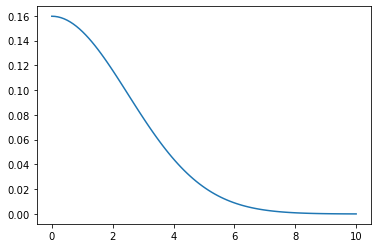

In [32]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))
     
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

plot_func(partial(gaussian, bw=2.5))

In [33]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [34]:
X = data.clone()
x = X[0]
x

tensor([26.204, 26.349])

In [35]:
dist = ((x-X)**2).sum(1).sqrt()
dist

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [36]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [37]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [38]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        # weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()
     

def meanshift(data):
    X = data.clone()
    for it in range(15): one_update(X)
    return X

In [39]:
%time X=meanshift(data)

Wall time: 3.1 s


In [40]:
X

tensor([[26.792, 29.120],
        [26.792, 29.120],
        [26.792, 29.120],
        ...,
        [30.433,  6.471],
        [30.433,  6.471],
        [30.433,  6.471]])

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
     

def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)
     
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)
     

# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

#### GPU Batched Algorithm

In [42]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape
     

def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()
     

dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [43]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [44]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [45]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [46]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [47]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [48]:
print(num)
print(weight@X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])
tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])


In [49]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [50]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X


data = data.cuda()
     

X = meanshift(data)
     

%timeit -n 5 _=meanshift(data, 1250)

The slowest run took 20.51 times longer than the fastest. This could mean that an intermediate result is being cached.
13.7 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
